In [1]:
%matplotlib inline

import os

import torch
import gpytorch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import linalg
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import PathToSubmol, FindAtomEnvironmentOfRadiusN, MolToSmiles
from rdkit.Chem.AtomPairs import Pairs
from MDAnalysis.analysis.rms import rmsd
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from map4 import MAP4Calculator
import tmap as tm


from mobius import ForceField, VirtualTarget

In [6]:
mhci = pd.read_csv('binding_data_2013/bdata.20130222.mhci.csv')

In [7]:
# We removed those binding affinity values
# A lot of peptides were set with those values. Looks like some default values assigned...
dirty_values = [1, 2, 3, 5000, 10000, 20000, 43424, 50000, 69444.44444, 78125]

# Split dataset in training and testing sets
mhci = mhci[(mhci['mhc_allele'] == 'HLA-A*02:01') &
                (mhci['length'] == 9) &
                (~mhci['affinity_binding'].isin(dirty_values))]

### MAP4 fingerprint + Tanimoto similarity kernel

In [96]:
class CosineSimilarityKernel(gpytorch.kernels.Kernel):
    # the sequence kernel is stationary
    is_stationary = True     

    # this is the kernel function
    def forward(self, x1, x2, **params):
        # Source: https://stackoverflow.com/questions/50411191/how-to-compute-the-cosine-similarity-in-pytorch-for-all-rows-in-a-matrix-with-re
        eps=1e-8
        
        # Normalize the rows, before computing their dot products via transposition
        x1_n = x1.norm(dim=1)[:, None]
        x2_n = x2.norm(dim=1)[:, None]
        x1_norm = x1 / torch.max(x1_n, eps * torch.ones_like(x1_n))
        x2_norm = x2 / torch.max(x2_n, eps * torch.ones_like(x2_n))
        sim_mt = torch.mm(x1_norm, x2_norm.transpose(0, 1))
        return sim_mt


class TanimotoSimilarityKernel(gpytorch.kernels.Kernel):
    # the sequence kernel is stationary
    is_stationary = True     

    # this is the kernel function
    def forward(self, x1, x2, **params):
        x1s = torch.sum(torch.square(x1), dim=-1)
        x2s = torch.sum(torch.square(x2), dim=-1)
        product = torch.mm(x1, x2.transpose(1, 0))
        denominator = torch.add(x2s, x1s[:, None]) - product
        sim_mt = product / denominator
        return sim_mt

    
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(TanimotoSimilarityKernel())
        #self.covar_module = gpytorch.kernels.ScaleKernel(CosineSimilarityKernel())
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=.5))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
    
# Wrap training, prediction and plotting from the ExactGP-Tutorial into a function,
# so that we do not have to repeat the code later on
def train(model, likelihood, train_x, train_y, training_iter=100):
    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        
        print('Iter %04d/%d - Loss: %.3f   noise: %.3f   kernel scale: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.likelihood.noise.item(),
            model.covar_module.raw_outputscale
        ))
        
        optimizer.step()

In [100]:
def predict(model, likelihood, test_x):
    model.eval()
    likelihood.eval()
    
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        # Test points are regularly spaced along [0,1]
        return likelihood(model(test_x))


def plot(y_test, observed_pred, fig_filename=None):
    with torch.no_grad():
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        
        ax.scatter(y_test, observed_pred)
        
        ax.set_xlim([np.min([y_test, observed_pred]) - 1, np.max([y_test, observed_pred]) + 1])
        ax.set_ylim([np.min([y_test, observed_pred]) - 1, np.max([y_test, observed_pred]) + 1])
        ax.set_xlabel('Experimental values (kcal/mol)', fontsize=20)
        ax.set_ylabel('Predicted values (kcal/mol)', fontsize=20)
        
        if fig_filename is not None:
            plt.savefig(fig_filename, bbox_inches='tight', dpi=300)
        
        plt.show()

In [63]:
def map4_fingerprint(sequences, dimensions=4096, radius=2, is_folded=True):
    MAP4_unf = MAP4Calculator(dimensions=dimensions, radius=radius, is_folded=is_folded)
    fps = MAP4_unf.calculate_many([Chem.rdmolfiles.MolFromFASTA(s) for s in sequences])
    return torch.from_numpy(np.array(fps)).float()

## Random train-test (70/30) split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(mhci['sequence'], mhci['energy'], test_size=0.3)

print(X_train.shape, X_test.shape)

X_train_fps = map4_fingerprint(X_train)
X_test_fps = map4_fingerprint(X_test)

y_train = torch.from_numpy(y_train.values).float()
y_test = torch.from_numpy(y_test.values).float()

(4076,) (1747,)


In [71]:
# Initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_train_fps, y_train, likelihood)

# Train GP model
train(model, likelihood, X_train_fps, y_train, training_iter=1000)

Iter 0001/1000 - Loss: 1.956   noise: 0.693   kernel scale: 0.000
Iter 0002/1000 - Loss: 1.918   noise: 0.744   kernel scale: 0.100
Iter 0003/1000 - Loss: 1.886   noise: 0.798   kernel scale: 0.199
Iter 0004/1000 - Loss: 1.858   noise: 0.853   kernel scale: 0.298
Iter 0005/1000 - Loss: 1.834   noise: 0.908   kernel scale: 0.395
Iter 0006/1000 - Loss: 1.816   noise: 0.964   kernel scale: 0.491
Iter 0007/1000 - Loss: 1.802   noise: 1.020   kernel scale: 0.585
Iter 0008/1000 - Loss: 1.791   noise: 1.074   kernel scale: 0.677
Iter 0009/1000 - Loss: 1.781   noise: 1.126   kernel scale: 0.767
Iter 0010/1000 - Loss: 1.773   noise: 1.175   kernel scale: 0.854
Iter 0011/1000 - Loss: 1.770   noise: 1.221   kernel scale: 0.938
Iter 0012/1000 - Loss: 1.763   noise: 1.264   kernel scale: 1.020
Iter 0013/1000 - Loss: 1.760   noise: 1.302   kernel scale: 1.098
Iter 0014/1000 - Loss: 1.758   noise: 1.336   kernel scale: 1.174
Iter 0015/1000 - Loss: 1.755   noise: 1.365   kernel scale: 1.247
Iter 0016/

Iter 0126/1000 - Loss: 1.712   noise: 0.723   kernel scale: 3.769
Iter 0127/1000 - Loss: 1.708   noise: 0.722   kernel scale: 3.775
Iter 0128/1000 - Loss: 1.708   noise: 0.721   kernel scale: 3.782
Iter 0129/1000 - Loss: 1.708   noise: 0.720   kernel scale: 3.788
Iter 0130/1000 - Loss: 1.708   noise: 0.718   kernel scale: 3.794
Iter 0131/1000 - Loss: 1.706   noise: 0.716   kernel scale: 3.800
Iter 0132/1000 - Loss: 1.712   noise: 0.715   kernel scale: 3.806
Iter 0133/1000 - Loss: 1.707   noise: 0.713   kernel scale: 3.811
Iter 0134/1000 - Loss: 1.707   noise: 0.712   kernel scale: 3.817
Iter 0135/1000 - Loss: 1.704   noise: 0.711   kernel scale: 3.823
Iter 0136/1000 - Loss: 1.705   noise: 0.709   kernel scale: 3.829
Iter 0137/1000 - Loss: 1.711   noise: 0.708   kernel scale: 3.834
Iter 0138/1000 - Loss: 1.707   noise: 0.707   kernel scale: 3.840
Iter 0139/1000 - Loss: 1.704   noise: 0.705   kernel scale: 3.845
Iter 0140/1000 - Loss: 1.707   noise: 0.704   kernel scale: 3.851
Iter 0141/

Iter 0251/1000 - Loss: 1.704   noise: 0.655   kernel scale: 4.142
Iter 0252/1000 - Loss: 1.708   noise: 0.655   kernel scale: 4.143
Iter 0253/1000 - Loss: 1.709   noise: 0.655   kernel scale: 4.144
Iter 0254/1000 - Loss: 1.707   noise: 0.655   kernel scale: 4.145
Iter 0255/1000 - Loss: 1.704   noise: 0.656   kernel scale: 4.146
Iter 0256/1000 - Loss: 1.704   noise: 0.656   kernel scale: 4.147
Iter 0257/1000 - Loss: 1.705   noise: 0.657   kernel scale: 4.149
Iter 0258/1000 - Loss: 1.705   noise: 0.658   kernel scale: 4.150
Iter 0259/1000 - Loss: 1.709   noise: 0.658   kernel scale: 4.152
Iter 0260/1000 - Loss: 1.706   noise: 0.659   kernel scale: 4.154
Iter 0261/1000 - Loss: 1.708   noise: 0.661   kernel scale: 4.156
Iter 0262/1000 - Loss: 1.708   noise: 0.662   kernel scale: 4.157
Iter 0263/1000 - Loss: 1.711   noise: 0.663   kernel scale: 4.159
Iter 0264/1000 - Loss: 1.709   noise: 0.665   kernel scale: 4.161
Iter 0265/1000 - Loss: 1.702   noise: 0.666   kernel scale: 4.162
Iter 0266/

Iter 0376/1000 - Loss: 1.701   noise: 0.655   kernel scale: 4.175
Iter 0377/1000 - Loss: 1.708   noise: 0.655   kernel scale: 4.175
Iter 0378/1000 - Loss: 1.707   noise: 0.655   kernel scale: 4.174
Iter 0379/1000 - Loss: 1.710   noise: 0.654   kernel scale: 4.174
Iter 0380/1000 - Loss: 1.711   noise: 0.654   kernel scale: 4.173
Iter 0381/1000 - Loss: 1.709   noise: 0.655   kernel scale: 4.173
Iter 0382/1000 - Loss: 1.708   noise: 0.655   kernel scale: 4.172
Iter 0383/1000 - Loss: 1.707   noise: 0.656   kernel scale: 4.172
Iter 0384/1000 - Loss: 1.707   noise: 0.656   kernel scale: 4.171
Iter 0385/1000 - Loss: 1.708   noise: 0.656   kernel scale: 4.170
Iter 0386/1000 - Loss: 1.710   noise: 0.656   kernel scale: 4.170
Iter 0387/1000 - Loss: 1.704   noise: 0.656   kernel scale: 4.169
Iter 0388/1000 - Loss: 1.707   noise: 0.656   kernel scale: 4.168
Iter 0389/1000 - Loss: 1.705   noise: 0.656   kernel scale: 4.167
Iter 0390/1000 - Loss: 1.706   noise: 0.656   kernel scale: 4.167
Iter 0391/

Iter 0501/1000 - Loss: 1.706   noise: 0.662   kernel scale: 4.178
Iter 0502/1000 - Loss: 1.705   noise: 0.661   kernel scale: 4.177
Iter 0503/1000 - Loss: 1.706   noise: 0.660   kernel scale: 4.177
Iter 0504/1000 - Loss: 1.705   noise: 0.659   kernel scale: 4.177
Iter 0505/1000 - Loss: 1.706   noise: 0.659   kernel scale: 4.177
Iter 0506/1000 - Loss: 1.703   noise: 0.658   kernel scale: 4.177
Iter 0507/1000 - Loss: 1.707   noise: 0.657   kernel scale: 4.178
Iter 0508/1000 - Loss: 1.703   noise: 0.657   kernel scale: 4.178
Iter 0509/1000 - Loss: 1.708   noise: 0.656   kernel scale: 4.178
Iter 0510/1000 - Loss: 1.707   noise: 0.655   kernel scale: 4.178
Iter 0511/1000 - Loss: 1.707   noise: 0.654   kernel scale: 4.178
Iter 0512/1000 - Loss: 1.707   noise: 0.653   kernel scale: 4.178
Iter 0513/1000 - Loss: 1.702   noise: 0.652   kernel scale: 4.178
Iter 0514/1000 - Loss: 1.705   noise: 0.650   kernel scale: 4.178
Iter 0515/1000 - Loss: 1.707   noise: 0.649   kernel scale: 4.178
Iter 0516/

Iter 0626/1000 - Loss: 1.707   noise: 0.654   kernel scale: 4.171
Iter 0627/1000 - Loss: 1.704   noise: 0.654   kernel scale: 4.170
Iter 0628/1000 - Loss: 1.706   noise: 0.653   kernel scale: 4.169
Iter 0629/1000 - Loss: 1.705   noise: 0.652   kernel scale: 4.169
Iter 0630/1000 - Loss: 1.708   noise: 0.652   kernel scale: 4.168
Iter 0631/1000 - Loss: 1.709   noise: 0.652   kernel scale: 4.168
Iter 0632/1000 - Loss: 1.704   noise: 0.653   kernel scale: 4.169
Iter 0633/1000 - Loss: 1.702   noise: 0.654   kernel scale: 4.169
Iter 0634/1000 - Loss: 1.711   noise: 0.655   kernel scale: 4.170
Iter 0635/1000 - Loss: 1.707   noise: 0.656   kernel scale: 4.171
Iter 0636/1000 - Loss: 1.704   noise: 0.657   kernel scale: 4.173
Iter 0637/1000 - Loss: 1.705   noise: 0.659   kernel scale: 4.174
Iter 0638/1000 - Loss: 1.706   noise: 0.660   kernel scale: 4.175
Iter 0639/1000 - Loss: 1.710   noise: 0.660   kernel scale: 4.176
Iter 0640/1000 - Loss: 1.707   noise: 0.661   kernel scale: 4.177
Iter 0641/

Iter 0751/1000 - Loss: 1.708   noise: 0.657   kernel scale: 4.161
Iter 0752/1000 - Loss: 1.704   noise: 0.656   kernel scale: 4.160
Iter 0753/1000 - Loss: 1.707   noise: 0.654   kernel scale: 4.160
Iter 0754/1000 - Loss: 1.708   noise: 0.652   kernel scale: 4.159
Iter 0755/1000 - Loss: 1.703   noise: 0.651   kernel scale: 4.158
Iter 0756/1000 - Loss: 1.712   noise: 0.649   kernel scale: 4.158
Iter 0757/1000 - Loss: 1.704   noise: 0.649   kernel scale: 4.158
Iter 0758/1000 - Loss: 1.705   noise: 0.650   kernel scale: 4.159
Iter 0759/1000 - Loss: 1.700   noise: 0.650   kernel scale: 4.160
Iter 0760/1000 - Loss: 1.706   noise: 0.651   kernel scale: 4.162
Iter 0761/1000 - Loss: 1.708   noise: 0.651   kernel scale: 4.164
Iter 0762/1000 - Loss: 1.707   noise: 0.652   kernel scale: 4.166
Iter 0763/1000 - Loss: 1.708   noise: 0.652   kernel scale: 4.168
Iter 0764/1000 - Loss: 1.708   noise: 0.653   kernel scale: 4.169
Iter 0765/1000 - Loss: 1.711   noise: 0.653   kernel scale: 4.170
Iter 0766/

Iter 0876/1000 - Loss: 1.705   noise: 0.656   kernel scale: 4.170
Iter 0877/1000 - Loss: 1.707   noise: 0.656   kernel scale: 4.170
Iter 0878/1000 - Loss: 1.707   noise: 0.656   kernel scale: 4.171
Iter 0879/1000 - Loss: 1.710   noise: 0.656   kernel scale: 4.171
Iter 0880/1000 - Loss: 1.709   noise: 0.656   kernel scale: 4.170
Iter 0881/1000 - Loss: 1.702   noise: 0.656   kernel scale: 4.170
Iter 0882/1000 - Loss: 1.700   noise: 0.656   kernel scale: 4.171
Iter 0883/1000 - Loss: 1.707   noise: 0.655   kernel scale: 4.171
Iter 0884/1000 - Loss: 1.709   noise: 0.655   kernel scale: 4.172
Iter 0885/1000 - Loss: 1.711   noise: 0.655   kernel scale: 4.173
Iter 0886/1000 - Loss: 1.705   noise: 0.654   kernel scale: 4.173
Iter 0887/1000 - Loss: 1.708   noise: 0.653   kernel scale: 4.172
Iter 0888/1000 - Loss: 1.708   noise: 0.652   kernel scale: 4.171
Iter 0889/1000 - Loss: 1.706   noise: 0.651   kernel scale: 4.171
Iter 0890/1000 - Loss: 1.708   noise: 0.652   kernel scale: 4.171
Iter 0891/

R2   : 0.621
RMSD : 1.252 kcal/mol


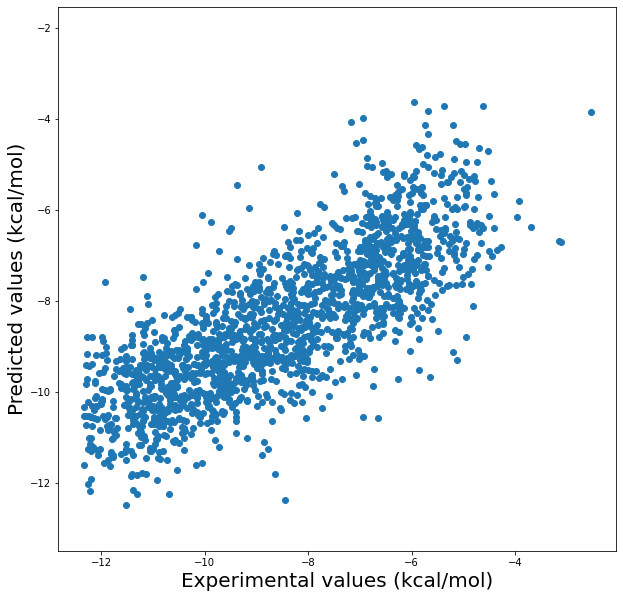

In [72]:
# Predict energy for test set
observed_pred = predict(model, likelihood, X_test_fps)
 
print('R2   : %.3f' % pearsonr(y_test, observed_pred.mean.numpy())[0]**2)
print('RMSD : %.3f kcal/mol' % rmsd(y_test, observed_pred.mean.numpy()))

# Plot results
#plot(y_test.numpy(), observed_pred.mean.numpy(), fig_filename='correlation_exp_pred_MAP4_fps_tanimoto_mhc-i_cleaned_rerun.png')
plot(y_test.numpy(), observed_pred.mean.numpy(), fig_filename=None)

## Random train-test (20/80) split

In [105]:
X_train, X_test, y_train, y_test = train_test_split(mhci['sequence'], mhci['energy'], test_size=0.8)

print('Train: %4d - %.3f %%' % (X_train.shape[0], X_train.shape[0]/mhci.shape[0]* 100.))
print('Test : %4d - %.3f %%' % (X_test.shape[0], X_test.shape[0]/mhci.shape[0]* 100.))

Train: 1164 - 19.990 %
Test : 4659 - 80.010 %


In [106]:
X_train_fps = map4_fingerprint(X_train)
X_test_fps = map4_fingerprint(X_test)

y_train = torch.from_numpy(y_train.values).float()
y_test = torch.from_numpy(y_test.values).float()

In [107]:
# Initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_train_fps, y_train, likelihood)

# Train GP model
train(model, likelihood, X_train_fps, y_train, training_iter=1000)

/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:278: UserWarning: An output with one or more elements was resized since it had shape [11], which does not match the required output shape [1, 11].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272168290/work/aten/src/ATen/native/Resize.cpp:23.)
  curr_conjugate_vec,


Iter 0001/1000 - Loss: 2.247   noise: 0.693   kernel scale: 0.000
Iter 0002/1000 - Loss: 2.189   noise: 0.744   kernel scale: 0.100
Iter 0003/1000 - Loss: 2.141   noise: 0.798   kernel scale: 0.200
Iter 0004/1000 - Loss: 2.093   noise: 0.853   kernel scale: 0.298
Iter 0005/1000 - Loss: 2.055   noise: 0.909   kernel scale: 0.396
Iter 0006/1000 - Loss: 2.029   noise: 0.966   kernel scale: 0.492
Iter 0007/1000 - Loss: 2.001   noise: 1.024   kernel scale: 0.586
Iter 0008/1000 - Loss: 1.977   noise: 1.081   kernel scale: 0.678
Iter 0009/1000 - Loss: 1.962   noise: 1.137   kernel scale: 0.769
Iter 0010/1000 - Loss: 1.943   noise: 1.192   kernel scale: 0.857
Iter 0011/1000 - Loss: 1.931   noise: 1.245   kernel scale: 0.942
Iter 0012/1000 - Loss: 1.922   noise: 1.296   kernel scale: 1.025
Iter 0013/1000 - Loss: 1.913   noise: 1.344   kernel scale: 1.105
Iter 0014/1000 - Loss: 1.905   noise: 1.390   kernel scale: 1.182
Iter 0015/1000 - Loss: 1.902   noise: 1.432   kernel scale: 1.257
Iter 0016/

Iter 0130/1000 - Loss: 1.809   noise: 0.700   kernel scale: 4.015
Iter 0131/1000 - Loss: 1.829   noise: 0.697   kernel scale: 4.026
Iter 0132/1000 - Loss: 1.817   noise: 0.694   kernel scale: 4.038
Iter 0133/1000 - Loss: 1.816   noise: 0.691   kernel scale: 4.049
Iter 0134/1000 - Loss: 1.808   noise: 0.688   kernel scale: 4.061
Iter 0135/1000 - Loss: 1.813   noise: 0.685   kernel scale: 4.072
Iter 0136/1000 - Loss: 1.811   noise: 0.682   kernel scale: 4.083
Iter 0137/1000 - Loss: 1.813   noise: 0.679   kernel scale: 4.095
Iter 0138/1000 - Loss: 1.817   noise: 0.676   kernel scale: 4.106
Iter 0139/1000 - Loss: 1.811   noise: 0.674   kernel scale: 4.117
Iter 0140/1000 - Loss: 1.813   noise: 0.671   kernel scale: 4.127
Iter 0141/1000 - Loss: 1.807   noise: 0.668   kernel scale: 4.138
Iter 0142/1000 - Loss: 1.810   noise: 0.665   kernel scale: 4.149
Iter 0143/1000 - Loss: 1.814   noise: 0.662   kernel scale: 4.160
Iter 0144/1000 - Loss: 1.808   noise: 0.659   kernel scale: 4.170
Iter 0145/

Iter 0258/1000 - Loss: 1.805   noise: 0.481   kernel scale: 4.938
Iter 0259/1000 - Loss: 1.804   noise: 0.480   kernel scale: 4.942
Iter 0260/1000 - Loss: 1.810   noise: 0.479   kernel scale: 4.946
Iter 0261/1000 - Loss: 1.810   noise: 0.478   kernel scale: 4.950
Iter 0262/1000 - Loss: 1.815   noise: 0.477   kernel scale: 4.953
Iter 0263/1000 - Loss: 1.810   noise: 0.476   kernel scale: 4.957
Iter 0264/1000 - Loss: 1.818   noise: 0.476   kernel scale: 4.961
Iter 0265/1000 - Loss: 1.803   noise: 0.475   kernel scale: 4.964
Iter 0266/1000 - Loss: 1.808   noise: 0.474   kernel scale: 4.968
Iter 0267/1000 - Loss: 1.814   noise: 0.473   kernel scale: 4.971
Iter 0268/1000 - Loss: 1.813   noise: 0.472   kernel scale: 4.975
Iter 0269/1000 - Loss: 1.809   noise: 0.472   kernel scale: 4.978
Iter 0270/1000 - Loss: 1.809   noise: 0.471   kernel scale: 4.981
Iter 0271/1000 - Loss: 1.805   noise: 0.470   kernel scale: 4.985
Iter 0272/1000 - Loss: 1.807   noise: 0.469   kernel scale: 4.988
Iter 0273/

Iter 0388/1000 - Loss: 1.812   noise: 0.418   kernel scale: 5.225
Iter 0389/1000 - Loss: 1.807   noise: 0.418   kernel scale: 5.226
Iter 0390/1000 - Loss: 1.811   noise: 0.418   kernel scale: 5.227
Iter 0391/1000 - Loss: 1.805   noise: 0.417   kernel scale: 5.228
Iter 0392/1000 - Loss: 1.807   noise: 0.417   kernel scale: 5.229
Iter 0393/1000 - Loss: 1.808   noise: 0.417   kernel scale: 5.230
Iter 0394/1000 - Loss: 1.809   noise: 0.417   kernel scale: 5.231
Iter 0395/1000 - Loss: 1.813   noise: 0.416   kernel scale: 5.231
Iter 0396/1000 - Loss: 1.807   noise: 0.416   kernel scale: 5.232
Iter 0397/1000 - Loss: 1.813   noise: 0.416   kernel scale: 5.233
Iter 0398/1000 - Loss: 1.818   noise: 0.415   kernel scale: 5.234
Iter 0399/1000 - Loss: 1.814   noise: 0.415   kernel scale: 5.234
Iter 0400/1000 - Loss: 1.808   noise: 0.415   kernel scale: 5.235
Iter 0401/1000 - Loss: 1.810   noise: 0.415   kernel scale: 5.236
Iter 0402/1000 - Loss: 1.813   noise: 0.415   kernel scale: 5.236
Iter 0403/

Iter 0513/1000 - Loss: 1.817   noise: 0.398   kernel scale: 5.300
Iter 0514/1000 - Loss: 1.809   noise: 0.398   kernel scale: 5.300
Iter 0515/1000 - Loss: 1.801   noise: 0.398   kernel scale: 5.301
Iter 0516/1000 - Loss: 1.808   noise: 0.398   kernel scale: 5.301
Iter 0517/1000 - Loss: 1.808   noise: 0.398   kernel scale: 5.302
Iter 0518/1000 - Loss: 1.816   noise: 0.398   kernel scale: 5.302
Iter 0519/1000 - Loss: 1.803   noise: 0.397   kernel scale: 5.303
Iter 0520/1000 - Loss: 1.813   noise: 0.397   kernel scale: 5.303
Iter 0521/1000 - Loss: 1.805   noise: 0.397   kernel scale: 5.304
Iter 0522/1000 - Loss: 1.814   noise: 0.397   kernel scale: 5.304
Iter 0523/1000 - Loss: 1.813   noise: 0.397   kernel scale: 5.305
Iter 0524/1000 - Loss: 1.814   noise: 0.397   kernel scale: 5.305
Iter 0525/1000 - Loss: 1.806   noise: 0.397   kernel scale: 5.306
Iter 0526/1000 - Loss: 1.809   noise: 0.397   kernel scale: 5.307
Iter 0527/1000 - Loss: 1.808   noise: 0.397   kernel scale: 5.308
Iter 0528/

Iter 0639/1000 - Loss: 1.814   noise: 0.392   kernel scale: 5.325
Iter 0640/1000 - Loss: 1.808   noise: 0.392   kernel scale: 5.326
Iter 0641/1000 - Loss: 1.809   noise: 0.392   kernel scale: 5.326
Iter 0642/1000 - Loss: 1.817   noise: 0.392   kernel scale: 5.326
Iter 0643/1000 - Loss: 1.808   noise: 0.392   kernel scale: 5.327
Iter 0644/1000 - Loss: 1.805   noise: 0.392   kernel scale: 5.327
Iter 0645/1000 - Loss: 1.810   noise: 0.392   kernel scale: 5.327
Iter 0646/1000 - Loss: 1.806   noise: 0.392   kernel scale: 5.327
Iter 0647/1000 - Loss: 1.815   noise: 0.392   kernel scale: 5.328
Iter 0648/1000 - Loss: 1.810   noise: 0.392   kernel scale: 5.328
Iter 0649/1000 - Loss: 1.812   noise: 0.392   kernel scale: 5.328
Iter 0650/1000 - Loss: 1.805   noise: 0.392   kernel scale: 5.328
Iter 0651/1000 - Loss: 1.813   noise: 0.392   kernel scale: 5.328
Iter 0652/1000 - Loss: 1.808   noise: 0.392   kernel scale: 5.329
Iter 0653/1000 - Loss: 1.810   noise: 0.392   kernel scale: 5.329
Iter 0654/

Iter 0765/1000 - Loss: 1.816   noise: 0.388   kernel scale: 5.349
Iter 0766/1000 - Loss: 1.810   noise: 0.388   kernel scale: 5.349
Iter 0767/1000 - Loss: 1.806   noise: 0.388   kernel scale: 5.349
Iter 0768/1000 - Loss: 1.806   noise: 0.388   kernel scale: 5.348
Iter 0769/1000 - Loss: 1.806   noise: 0.388   kernel scale: 5.348
Iter 0770/1000 - Loss: 1.815   noise: 0.388   kernel scale: 5.349
Iter 0771/1000 - Loss: 1.814   noise: 0.388   kernel scale: 5.349
Iter 0772/1000 - Loss: 1.814   noise: 0.388   kernel scale: 5.349
Iter 0773/1000 - Loss: 1.806   noise: 0.389   kernel scale: 5.349
Iter 0774/1000 - Loss: 1.812   noise: 0.389   kernel scale: 5.348
Iter 0775/1000 - Loss: 1.807   noise: 0.389   kernel scale: 5.348
Iter 0776/1000 - Loss: 1.808   noise: 0.389   kernel scale: 5.348
Iter 0777/1000 - Loss: 1.816   noise: 0.389   kernel scale: 5.348
Iter 0778/1000 - Loss: 1.805   noise: 0.390   kernel scale: 5.347
Iter 0779/1000 - Loss: 1.805   noise: 0.390   kernel scale: 5.347
Iter 0780/

Iter 0895/1000 - Loss: 1.810   noise: 0.395   kernel scale: 5.328
Iter 0896/1000 - Loss: 1.808   noise: 0.395   kernel scale: 5.328
Iter 0897/1000 - Loss: 1.813   noise: 0.395   kernel scale: 5.327
Iter 0898/1000 - Loss: 1.808   noise: 0.395   kernel scale: 5.327
Iter 0899/1000 - Loss: 1.807   noise: 0.395   kernel scale: 5.326
Iter 0900/1000 - Loss: 1.806   noise: 0.395   kernel scale: 5.326
Iter 0901/1000 - Loss: 1.806   noise: 0.395   kernel scale: 5.325
Iter 0902/1000 - Loss: 1.810   noise: 0.395   kernel scale: 5.325
Iter 0903/1000 - Loss: 1.806   noise: 0.394   kernel scale: 5.325
Iter 0904/1000 - Loss: 1.817   noise: 0.394   kernel scale: 5.324
Iter 0905/1000 - Loss: 1.816   noise: 0.394   kernel scale: 5.324
Iter 0906/1000 - Loss: 1.807   noise: 0.394   kernel scale: 5.324
Iter 0907/1000 - Loss: 1.801   noise: 0.394   kernel scale: 5.323
Iter 0908/1000 - Loss: 1.814   noise: 0.394   kernel scale: 5.323
Iter 0909/1000 - Loss: 1.808   noise: 0.393   kernel scale: 5.323
Iter 0910/

R2   : 0.517
RMSD : 1.384 kcal/mol


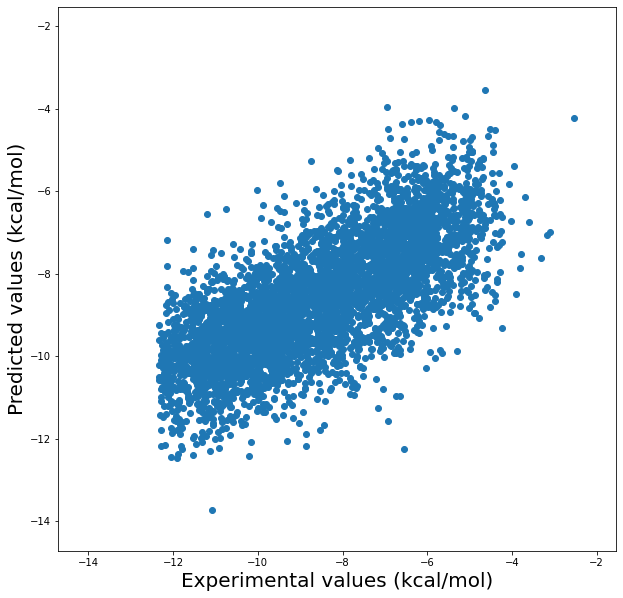

In [108]:
# Predict energy for test set
observed_pred = predict(model, likelihood, X_test_fps)
 
print('R2   : %.3f' % pearsonr(y_test, observed_pred.mean.numpy())[0]**2)
print('RMSD : %.3f kcal/mol' % rmsd(y_test, observed_pred.mean.numpy()))

# Plot results
plot(y_test.numpy(), observed_pred.mean.numpy(), fig_filename='correlation_exp_pred_MAP4_fps_tanimoto_mhc-i_cleaned_random_split_train_20_test_80.png')

## Random train-test (5/90) split

In [109]:
X_train, X_test, y_train, y_test = train_test_split(mhci['sequence'], mhci['energy'], test_size=0.95)

print('Train: %4d - %.3f %%' % (X_train.shape[0], X_train.shape[0]/mhci.shape[0]* 100.))
print('Test : %4d - %.3f %%' % (X_test.shape[0], X_test.shape[0]/mhci.shape[0]* 100.))

Train:  291 - 4.997 %
Test : 5532 - 95.003 %


In [110]:
X_train_fps = map4_fingerprint(X_train)
X_test_fps = map4_fingerprint(X_test)

y_train = torch.from_numpy(y_train.values).float()
y_test = torch.from_numpy(y_test.values).float()

In [111]:
# Initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_train_fps, y_train, likelihood)

# Train GP model
train(model, likelihood, X_train_fps, y_train, training_iter=1000)

Iter 0001/1000 - Loss: 2.692   noise: 0.693   kernel scale: 0.000
Iter 0002/1000 - Loss: 2.598   noise: 0.744   kernel scale: 0.100
Iter 0003/1000 - Loss: 2.517   noise: 0.798   kernel scale: 0.200
Iter 0004/1000 - Loss: 2.445   noise: 0.853   kernel scale: 0.298
Iter 0005/1000 - Loss: 2.383   noise: 0.910   kernel scale: 0.396
Iter 0006/1000 - Loss: 2.330   noise: 0.967   kernel scale: 0.492
Iter 0007/1000 - Loss: 2.283   noise: 1.025   kernel scale: 0.586
Iter 0008/1000 - Loss: 2.243   noise: 1.084   kernel scale: 0.679
Iter 0009/1000 - Loss: 2.209   noise: 1.142   kernel scale: 0.770
Iter 0010/1000 - Loss: 2.179   noise: 1.199   kernel scale: 0.858
Iter 0011/1000 - Loss: 2.154   noise: 1.255   kernel scale: 0.944
Iter 0012/1000 - Loss: 2.132   noise: 1.309   kernel scale: 1.027
Iter 0013/1000 - Loss: 2.114   noise: 1.361   kernel scale: 1.108
Iter 0014/1000 - Loss: 2.098   noise: 1.412   kernel scale: 1.186
Iter 0015/1000 - Loss: 2.084   noise: 1.459   kernel scale: 1.262
Iter 0016/

Iter 0151/1000 - Loss: 1.900   noise: 0.634   kernel scale: 4.092
Iter 0152/1000 - Loss: 1.899   noise: 0.630   kernel scale: 4.104
Iter 0153/1000 - Loss: 1.899   noise: 0.625   kernel scale: 4.116
Iter 0154/1000 - Loss: 1.899   noise: 0.621   kernel scale: 4.127
Iter 0155/1000 - Loss: 1.899   noise: 0.617   kernel scale: 4.139
Iter 0156/1000 - Loss: 1.899   noise: 0.612   kernel scale: 4.150
Iter 0157/1000 - Loss: 1.898   noise: 0.608   kernel scale: 4.162
Iter 0158/1000 - Loss: 1.898   noise: 0.604   kernel scale: 4.173
Iter 0159/1000 - Loss: 1.898   noise: 0.600   kernel scale: 4.185
Iter 0160/1000 - Loss: 1.898   noise: 0.596   kernel scale: 4.196
Iter 0161/1000 - Loss: 1.898   noise: 0.592   kernel scale: 4.207
Iter 0162/1000 - Loss: 1.897   noise: 0.588   kernel scale: 4.219
Iter 0163/1000 - Loss: 1.897   noise: 0.584   kernel scale: 4.230
Iter 0164/1000 - Loss: 1.897   noise: 0.580   kernel scale: 4.241
Iter 0165/1000 - Loss: 1.897   noise: 0.576   kernel scale: 4.252
Iter 0166/

Iter 0318/1000 - Loss: 1.886   noise: 0.216   kernel scale: 5.374
Iter 0319/1000 - Loss: 1.886   noise: 0.215   kernel scale: 5.378
Iter 0320/1000 - Loss: 1.886   noise: 0.214   kernel scale: 5.383
Iter 0321/1000 - Loss: 1.886   noise: 0.213   kernel scale: 5.387
Iter 0322/1000 - Loss: 1.886   noise: 0.212   kernel scale: 5.391
Iter 0323/1000 - Loss: 1.886   noise: 0.210   kernel scale: 5.395
Iter 0324/1000 - Loss: 1.886   noise: 0.209   kernel scale: 5.400
Iter 0325/1000 - Loss: 1.886   noise: 0.208   kernel scale: 5.404
Iter 0326/1000 - Loss: 1.886   noise: 0.207   kernel scale: 5.408
Iter 0327/1000 - Loss: 1.886   noise: 0.206   kernel scale: 5.412
Iter 0328/1000 - Loss: 1.886   noise: 0.204   kernel scale: 5.416
Iter 0329/1000 - Loss: 1.886   noise: 0.203   kernel scale: 5.420
Iter 0330/1000 - Loss: 1.886   noise: 0.202   kernel scale: 5.424
Iter 0331/1000 - Loss: 1.886   noise: 0.201   kernel scale: 5.428
Iter 0332/1000 - Loss: 1.886   noise: 0.200   kernel scale: 5.432
Iter 0333/

Iter 0471/1000 - Loss: 1.884   noise: 0.102   kernel scale: 5.773
Iter 0472/1000 - Loss: 1.884   noise: 0.102   kernel scale: 5.774
Iter 0473/1000 - Loss: 1.884   noise: 0.101   kernel scale: 5.775
Iter 0474/1000 - Loss: 1.884   noise: 0.101   kernel scale: 5.777
Iter 0475/1000 - Loss: 1.884   noise: 0.101   kernel scale: 5.778
Iter 0476/1000 - Loss: 1.884   noise: 0.100   kernel scale: 5.780
Iter 0477/1000 - Loss: 1.884   noise: 0.100   kernel scale: 5.781
Iter 0478/1000 - Loss: 1.884   noise: 0.099   kernel scale: 5.782
Iter 0479/1000 - Loss: 1.884   noise: 0.099   kernel scale: 5.784
Iter 0480/1000 - Loss: 1.884   noise: 0.099   kernel scale: 5.785
Iter 0481/1000 - Loss: 1.884   noise: 0.098   kernel scale: 5.786
Iter 0482/1000 - Loss: 1.884   noise: 0.098   kernel scale: 5.787
Iter 0483/1000 - Loss: 1.884   noise: 0.097   kernel scale: 5.789
Iter 0484/1000 - Loss: 1.884   noise: 0.097   kernel scale: 5.790
Iter 0485/1000 - Loss: 1.884   noise: 0.097   kernel scale: 5.791
Iter 0486/

Iter 0638/1000 - Loss: 1.883   noise: 0.058   kernel scale: 5.914
Iter 0639/1000 - Loss: 1.883   noise: 0.058   kernel scale: 5.915
Iter 0640/1000 - Loss: 1.883   noise: 0.058   kernel scale: 5.915
Iter 0641/1000 - Loss: 1.883   noise: 0.057   kernel scale: 5.916
Iter 0642/1000 - Loss: 1.883   noise: 0.057   kernel scale: 5.916
Iter 0643/1000 - Loss: 1.883   noise: 0.057   kernel scale: 5.917
Iter 0644/1000 - Loss: 1.883   noise: 0.057   kernel scale: 5.917
Iter 0645/1000 - Loss: 1.883   noise: 0.057   kernel scale: 5.918
Iter 0646/1000 - Loss: 1.883   noise: 0.057   kernel scale: 5.918
Iter 0647/1000 - Loss: 1.883   noise: 0.056   kernel scale: 5.918
Iter 0648/1000 - Loss: 1.883   noise: 0.056   kernel scale: 5.919
Iter 0649/1000 - Loss: 1.883   noise: 0.056   kernel scale: 5.919
Iter 0650/1000 - Loss: 1.883   noise: 0.056   kernel scale: 5.920
Iter 0651/1000 - Loss: 1.883   noise: 0.056   kernel scale: 5.920
Iter 0652/1000 - Loss: 1.883   noise: 0.056   kernel scale: 5.921
Iter 0653/

Iter 0800/1000 - Loss: 1.883   noise: 0.039   kernel scale: 5.970
Iter 0801/1000 - Loss: 1.883   noise: 0.039   kernel scale: 5.970
Iter 0802/1000 - Loss: 1.883   noise: 0.039   kernel scale: 5.971
Iter 0803/1000 - Loss: 1.883   noise: 0.038   kernel scale: 5.971
Iter 0804/1000 - Loss: 1.883   noise: 0.038   kernel scale: 5.971
Iter 0805/1000 - Loss: 1.883   noise: 0.038   kernel scale: 5.971
Iter 0806/1000 - Loss: 1.883   noise: 0.038   kernel scale: 5.972
Iter 0807/1000 - Loss: 1.883   noise: 0.038   kernel scale: 5.972
Iter 0808/1000 - Loss: 1.883   noise: 0.038   kernel scale: 5.972
Iter 0809/1000 - Loss: 1.883   noise: 0.038   kernel scale: 5.972
Iter 0810/1000 - Loss: 1.883   noise: 0.038   kernel scale: 5.972
Iter 0811/1000 - Loss: 1.883   noise: 0.038   kernel scale: 5.973
Iter 0812/1000 - Loss: 1.883   noise: 0.038   kernel scale: 5.973
Iter 0813/1000 - Loss: 1.883   noise: 0.038   kernel scale: 5.973
Iter 0814/1000 - Loss: 1.883   noise: 0.038   kernel scale: 5.973
Iter 0815/

Iter 0967/1000 - Loss: 1.883   noise: 0.028   kernel scale: 6.000
Iter 0968/1000 - Loss: 1.883   noise: 0.028   kernel scale: 6.000
Iter 0969/1000 - Loss: 1.883   noise: 0.028   kernel scale: 6.001
Iter 0970/1000 - Loss: 1.883   noise: 0.028   kernel scale: 6.001
Iter 0971/1000 - Loss: 1.883   noise: 0.028   kernel scale: 6.001
Iter 0972/1000 - Loss: 1.883   noise: 0.028   kernel scale: 6.001
Iter 0973/1000 - Loss: 1.883   noise: 0.028   kernel scale: 6.001
Iter 0974/1000 - Loss: 1.883   noise: 0.028   kernel scale: 6.001
Iter 0975/1000 - Loss: 1.883   noise: 0.027   kernel scale: 6.001
Iter 0976/1000 - Loss: 1.883   noise: 0.027   kernel scale: 6.002
Iter 0977/1000 - Loss: 1.883   noise: 0.027   kernel scale: 6.002
Iter 0978/1000 - Loss: 1.883   noise: 0.027   kernel scale: 6.002
Iter 0979/1000 - Loss: 1.883   noise: 0.027   kernel scale: 6.002
Iter 0980/1000 - Loss: 1.883   noise: 0.027   kernel scale: 6.002
Iter 0981/1000 - Loss: 1.883   noise: 0.027   kernel scale: 6.002
Iter 0982/

R2   : 0.383
RMSD : 1.568 kcal/mol


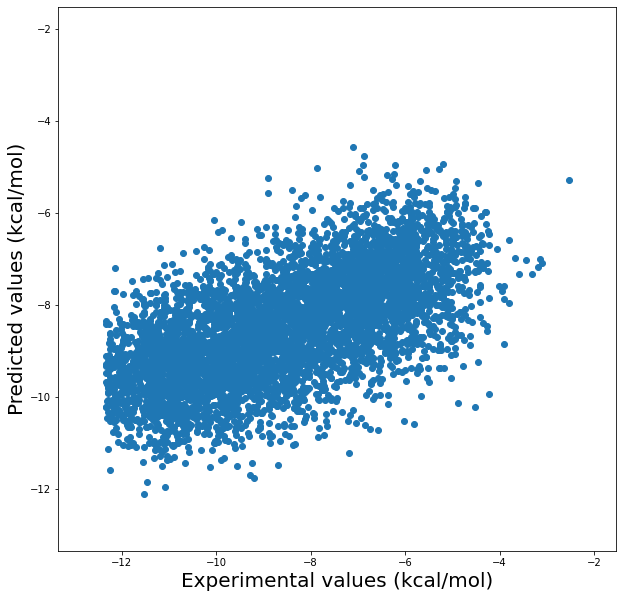

In [112]:
# Predict energy for test set
observed_pred = predict(model, likelihood, X_test_fps)
 
print('R2   : %.3f' % pearsonr(y_test, observed_pred.mean.numpy())[0]**2)
print('RMSD : %.3f kcal/mol' % rmsd(y_test, observed_pred.mean.numpy()))

# Plot results
plot(y_test.numpy(), observed_pred.mean.numpy(), fig_filename='correlation_exp_pred_MAP4_fps_tanimoto_mhc-i_cleaned_random_split_train_5_test_95.png')

## Random train-test (2/98) split

In [115]:
X_train, X_test, y_train, y_test = train_test_split(mhci['sequence'], mhci['energy'], test_size=0.98)

print('Train: %4d - %.3f %%' % (X_train.shape[0], X_train.shape[0]/mhci.shape[0]* 100.))
print('Test : %4d - %.3f %%' % (X_test.shape[0], X_test.shape[0]/mhci.shape[0]* 100.))

Train:  116 - 1.992 %
Test : 5707 - 98.008 %


In [116]:
X_train_fps = map4_fingerprint(X_train)
X_test_fps = map4_fingerprint(X_test)

y_train = torch.from_numpy(y_train.values).float()
y_test = torch.from_numpy(y_test.values).float()

In [117]:
# Initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_train_fps, y_train, likelihood)

# Train GP model
train(model, likelihood, X_train_fps, y_train, training_iter=1000)

Iter 0001/1000 - Loss: 3.389   noise: 0.693   kernel scale: 0.000
Iter 0002/1000 - Loss: 3.237   noise: 0.744   kernel scale: 0.100
Iter 0003/1000 - Loss: 3.103   noise: 0.798   kernel scale: 0.200
Iter 0004/1000 - Loss: 2.985   noise: 0.853   kernel scale: 0.298
Iter 0005/1000 - Loss: 2.881   noise: 0.910   kernel scale: 0.396
Iter 0006/1000 - Loss: 2.789   noise: 0.968   kernel scale: 0.492
Iter 0007/1000 - Loss: 2.710   noise: 1.027   kernel scale: 0.587
Iter 0008/1000 - Loss: 2.640   noise: 1.087   kernel scale: 0.679
Iter 0009/1000 - Loss: 2.579   noise: 1.146   kernel scale: 0.770
Iter 0010/1000 - Loss: 2.525   noise: 1.206   kernel scale: 0.858
Iter 0011/1000 - Loss: 2.478   noise: 1.264   kernel scale: 0.944
Iter 0012/1000 - Loss: 2.437   noise: 1.322   kernel scale: 1.028
Iter 0013/1000 - Loss: 2.401   noise: 1.379   kernel scale: 1.109
Iter 0014/1000 - Loss: 2.370   noise: 1.434   kernel scale: 1.187
Iter 0015/1000 - Loss: 2.342   noise: 1.487   kernel scale: 1.263
Iter 0016/

Iter 0202/1000 - Loss: 2.013   noise: 1.320   kernel scale: 3.638
Iter 0203/1000 - Loss: 2.013   noise: 1.318   kernel scale: 3.642
Iter 0204/1000 - Loss: 2.013   noise: 1.316   kernel scale: 3.646
Iter 0205/1000 - Loss: 2.013   noise: 1.314   kernel scale: 3.651
Iter 0206/1000 - Loss: 2.013   noise: 1.312   kernel scale: 3.655
Iter 0207/1000 - Loss: 2.013   noise: 1.310   kernel scale: 3.659
Iter 0208/1000 - Loss: 2.013   noise: 1.308   kernel scale: 3.664
Iter 0209/1000 - Loss: 2.013   noise: 1.306   kernel scale: 3.668
Iter 0210/1000 - Loss: 2.013   noise: 1.305   kernel scale: 3.672
Iter 0211/1000 - Loss: 2.013   noise: 1.303   kernel scale: 3.676
Iter 0212/1000 - Loss: 2.012   noise: 1.301   kernel scale: 3.681
Iter 0213/1000 - Loss: 2.012   noise: 1.299   kernel scale: 3.685
Iter 0214/1000 - Loss: 2.012   noise: 1.297   kernel scale: 3.689
Iter 0215/1000 - Loss: 2.012   noise: 1.295   kernel scale: 3.693
Iter 0216/1000 - Loss: 2.012   noise: 1.293   kernel scale: 3.698
Iter 0217/

Iter 0392/1000 - Loss: 2.008   noise: 0.993   kernel scale: 4.389
Iter 0393/1000 - Loss: 2.008   noise: 0.992   kernel scale: 4.393
Iter 0394/1000 - Loss: 2.008   noise: 0.990   kernel scale: 4.397
Iter 0395/1000 - Loss: 2.008   noise: 0.989   kernel scale: 4.400
Iter 0396/1000 - Loss: 2.008   noise: 0.987   kernel scale: 4.404
Iter 0397/1000 - Loss: 2.008   noise: 0.986   kernel scale: 4.408
Iter 0398/1000 - Loss: 2.008   noise: 0.984   kernel scale: 4.412
Iter 0399/1000 - Loss: 2.008   noise: 0.982   kernel scale: 4.415
Iter 0400/1000 - Loss: 2.008   noise: 0.981   kernel scale: 4.419
Iter 0401/1000 - Loss: 2.008   noise: 0.979   kernel scale: 4.423
Iter 0402/1000 - Loss: 2.008   noise: 0.978   kernel scale: 4.426
Iter 0403/1000 - Loss: 2.008   noise: 0.976   kernel scale: 4.430
Iter 0404/1000 - Loss: 2.008   noise: 0.975   kernel scale: 4.434
Iter 0405/1000 - Loss: 2.008   noise: 0.973   kernel scale: 4.437
Iter 0406/1000 - Loss: 2.008   noise: 0.971   kernel scale: 4.441
Iter 0407/

Iter 0603/1000 - Loss: 2.006   noise: 0.698   kernel scale: 5.098
Iter 0604/1000 - Loss: 2.006   noise: 0.697   kernel scale: 5.101
Iter 0605/1000 - Loss: 2.006   noise: 0.696   kernel scale: 5.104
Iter 0606/1000 - Loss: 2.006   noise: 0.694   kernel scale: 5.107
Iter 0607/1000 - Loss: 2.006   noise: 0.693   kernel scale: 5.110
Iter 0608/1000 - Loss: 2.006   noise: 0.692   kernel scale: 5.113
Iter 0609/1000 - Loss: 2.006   noise: 0.691   kernel scale: 5.116
Iter 0610/1000 - Loss: 2.006   noise: 0.690   kernel scale: 5.119
Iter 0611/1000 - Loss: 2.006   noise: 0.689   kernel scale: 5.122
Iter 0612/1000 - Loss: 2.006   noise: 0.687   kernel scale: 5.125
Iter 0613/1000 - Loss: 2.006   noise: 0.686   kernel scale: 5.128
Iter 0614/1000 - Loss: 2.006   noise: 0.685   kernel scale: 5.131
Iter 0615/1000 - Loss: 2.006   noise: 0.684   kernel scale: 5.133
Iter 0616/1000 - Loss: 2.006   noise: 0.683   kernel scale: 5.136
Iter 0617/1000 - Loss: 2.006   noise: 0.681   kernel scale: 5.139
Iter 0618/

Iter 0809/1000 - Loss: 2.004   noise: 0.492   kernel scale: 5.615
Iter 0810/1000 - Loss: 2.004   noise: 0.492   kernel scale: 5.617
Iter 0811/1000 - Loss: 2.004   noise: 0.491   kernel scale: 5.619
Iter 0812/1000 - Loss: 2.004   noise: 0.490   kernel scale: 5.621
Iter 0813/1000 - Loss: 2.004   noise: 0.489   kernel scale: 5.623
Iter 0814/1000 - Loss: 2.004   noise: 0.488   kernel scale: 5.625
Iter 0815/1000 - Loss: 2.004   noise: 0.487   kernel scale: 5.627
Iter 0816/1000 - Loss: 2.004   noise: 0.487   kernel scale: 5.629
Iter 0817/1000 - Loss: 2.004   noise: 0.486   kernel scale: 5.632
Iter 0818/1000 - Loss: 2.004   noise: 0.485   kernel scale: 5.634
Iter 0819/1000 - Loss: 2.004   noise: 0.484   kernel scale: 5.636
Iter 0820/1000 - Loss: 2.004   noise: 0.483   kernel scale: 5.638
Iter 0821/1000 - Loss: 2.004   noise: 0.483   kernel scale: 5.640
Iter 0822/1000 - Loss: 2.004   noise: 0.482   kernel scale: 5.642
Iter 0823/1000 - Loss: 2.004   noise: 0.481   kernel scale: 5.644
Iter 0824/

R2   : 0.299
RMSD : 1.697 kcal/mol


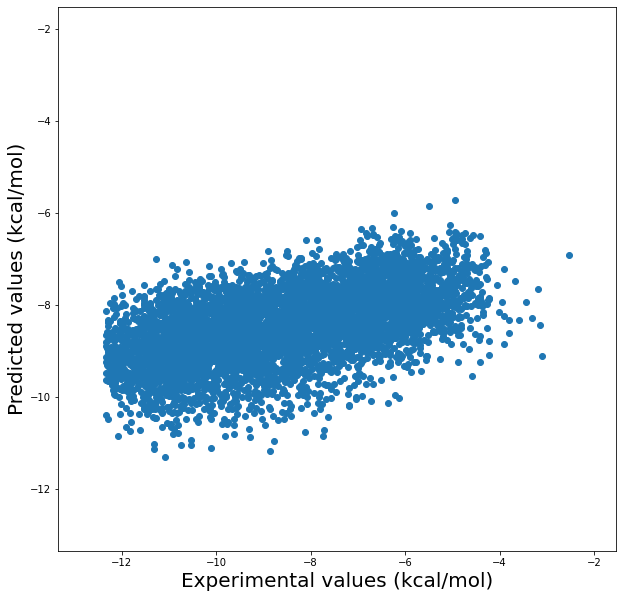

In [118]:
# Predict energy for test set
observed_pred = predict(model, likelihood, X_test_fps)
 
print('R2   : %.3f' % pearsonr(y_test, observed_pred.mean.numpy())[0]**2)
print('RMSD : %.3f kcal/mol' % rmsd(y_test, observed_pred.mean.numpy()))

# Plot results
plot(y_test.numpy(), observed_pred.mean.numpy(), fig_filename='correlation_exp_pred_MAP4_fps_tanimoto_mhc-i_cleaned_random_split_train_2_test_98.png')

# Low-high affinity split

In [125]:
low_affinity = mhci[mhci['energy'] >= -8.5]
high_affinity = mhci[mhci['energy'] < -8.5]

X_train, y_train = low_affinity['sequence'], low_affinity['energy']
X_test, y_test = high_affinity['sequence'], high_affinity['energy']

print('Train: %4d - %.3f %%' % (X_train.shape[0], X_train.shape[0]/mhci.shape[0]* 100.))
print('Test : %4d - %.3f %%' % (X_test.shape[0], X_test.shape[0]/mhci.shape[0]* 100.))

Train: 2882 - 49.493 %
Test : 2941 - 50.507 %


In [126]:
X_train_fps = map4_fingerprint(X_train)
X_test_fps = map4_fingerprint(X_test)

y_train = torch.from_numpy(y_train.values).float()
y_test = torch.from_numpy(y_test.values).float()

In [127]:
# Initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_train_fps, y_train, likelihood)

# Train GP model
train(model, likelihood, X_train_fps, y_train, training_iter=1000)

/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:234: UserWarning: An output with one or more elements was resized since it had shape [11], which does not match the required output shape [1, 11].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272168290/work/aten/src/ATen/native/Resize.cpp:23.)
  torch.sum(mul_storage, -2, keepdim=True, out=alpha)


Iter 0001/1000 - Loss: 1.383   noise: 0.693   kernel scale: 0.000
Iter 0002/1000 - Loss: 1.375   noise: 0.644   kernel scale: 0.100
Iter 0003/1000 - Loss: 1.371   noise: 0.599   kernel scale: 0.200
Iter 0004/1000 - Loss: 1.369   noise: 0.557   kernel scale: 0.299
Iter 0005/1000 - Loss: 1.365   noise: 0.522   kernel scale: 0.398
Iter 0006/1000 - Loss: 1.362   noise: 0.493   kernel scale: 0.496
Iter 0007/1000 - Loss: 1.356   noise: 0.470   kernel scale: 0.594
Iter 0008/1000 - Loss: 1.356   noise: 0.455   kernel scale: 0.691
Iter 0009/1000 - Loss: 1.356   noise: 0.446   kernel scale: 0.786
Iter 0010/1000 - Loss: 1.354   noise: 0.441   kernel scale: 0.880
Iter 0011/1000 - Loss: 1.352   noise: 0.439   kernel scale: 0.970
Iter 0012/1000 - Loss: 1.349   noise: 0.437   kernel scale: 1.055
Iter 0013/1000 - Loss: 1.353   noise: 0.434   kernel scale: 1.136
Iter 0014/1000 - Loss: 1.348   noise: 0.429   kernel scale: 1.208
Iter 0015/1000 - Loss: 1.349   noise: 0.422   kernel scale: 1.273
Iter 0016/

Iter 0126/1000 - Loss: 1.338   noise: 0.428   kernel scale: 1.070
Iter 0127/1000 - Loss: 1.340   noise: 0.431   kernel scale: 1.076
Iter 0128/1000 - Loss: 1.342   noise: 0.431   kernel scale: 1.079
Iter 0129/1000 - Loss: 1.341   noise: 0.429   kernel scale: 1.080
Iter 0130/1000 - Loss: 1.340   noise: 0.427   kernel scale: 1.083
Iter 0131/1000 - Loss: 1.341   noise: 0.423   kernel scale: 1.083
Iter 0132/1000 - Loss: 1.339   noise: 0.420   kernel scale: 1.085
Iter 0133/1000 - Loss: 1.344   noise: 0.416   kernel scale: 1.086
Iter 0134/1000 - Loss: 1.342   noise: 0.414   kernel scale: 1.088
Iter 0135/1000 - Loss: 1.343   noise: 0.413   kernel scale: 1.091
Iter 0136/1000 - Loss: 1.341   noise: 0.414   kernel scale: 1.095
Iter 0137/1000 - Loss: 1.342   noise: 0.416   kernel scale: 1.100
Iter 0138/1000 - Loss: 1.340   noise: 0.420   kernel scale: 1.104
Iter 0139/1000 - Loss: 1.343   noise: 0.424   kernel scale: 1.109
Iter 0140/1000 - Loss: 1.340   noise: 0.426   kernel scale: 1.110
Iter 0141/

Iter 0251/1000 - Loss: 1.342   noise: 0.435   kernel scale: 1.091
Iter 0252/1000 - Loss: 1.343   noise: 0.428   kernel scale: 1.086
Iter 0253/1000 - Loss: 1.342   noise: 0.421   kernel scale: 1.080
Iter 0254/1000 - Loss: 1.340   noise: 0.416   kernel scale: 1.078
Iter 0255/1000 - Loss: 1.342   noise: 0.413   kernel scale: 1.078
Iter 0256/1000 - Loss: 1.342   noise: 0.414   kernel scale: 1.082
Iter 0257/1000 - Loss: 1.341   noise: 0.417   kernel scale: 1.087
Iter 0258/1000 - Loss: 1.345   noise: 0.419   kernel scale: 1.091
Iter 0259/1000 - Loss: 1.341   noise: 0.421   kernel scale: 1.092
Iter 0260/1000 - Loss: 1.343   noise: 0.424   kernel scale: 1.094
Iter 0261/1000 - Loss: 1.345   noise: 0.428   kernel scale: 1.098
Iter 0262/1000 - Loss: 1.344   noise: 0.433   kernel scale: 1.099
Iter 0263/1000 - Loss: 1.345   noise: 0.434   kernel scale: 1.096
Iter 0264/1000 - Loss: 1.343   noise: 0.430   kernel scale: 1.084
Iter 0265/1000 - Loss: 1.343   noise: 0.425   kernel scale: 1.071
Iter 0266/

Iter 0376/1000 - Loss: 1.342   noise: 0.435   kernel scale: 1.103
Iter 0377/1000 - Loss: 1.340   noise: 0.430   kernel scale: 1.097
Iter 0378/1000 - Loss: 1.338   noise: 0.423   kernel scale: 1.089
Iter 0379/1000 - Loss: 1.340   noise: 0.416   kernel scale: 1.083
Iter 0380/1000 - Loss: 1.344   noise: 0.409   kernel scale: 1.077
Iter 0381/1000 - Loss: 1.340   noise: 0.409   kernel scale: 1.078
Iter 0382/1000 - Loss: 1.343   noise: 0.418   kernel scale: 1.093
Iter 0383/1000 - Loss: 1.340   noise: 0.430   kernel scale: 1.112
Iter 0384/1000 - Loss: 1.343   noise: 0.437   kernel scale: 1.123
Iter 0385/1000 - Loss: 1.343   noise: 0.437   kernel scale: 1.124
Iter 0386/1000 - Loss: 1.343   noise: 0.433   kernel scale: 1.120
Iter 0387/1000 - Loss: 1.341   noise: 0.426   kernel scale: 1.109
Iter 0388/1000 - Loss: 1.345   noise: 0.417   kernel scale: 1.095
Iter 0389/1000 - Loss: 1.339   noise: 0.411   kernel scale: 1.080
Iter 0390/1000 - Loss: 1.341   noise: 0.408   kernel scale: 1.072
Iter 0391/

Iter 0501/1000 - Loss: 1.342   noise: 0.430   kernel scale: 1.093
Iter 0502/1000 - Loss: 1.344   noise: 0.429   kernel scale: 1.091
Iter 0503/1000 - Loss: 1.344   noise: 0.424   kernel scale: 1.082
Iter 0504/1000 - Loss: 1.344   noise: 0.419   kernel scale: 1.069
Iter 0505/1000 - Loss: 1.340   noise: 0.415   kernel scale: 1.059
Iter 0506/1000 - Loss: 1.343   noise: 0.416   kernel scale: 1.058
Iter 0507/1000 - Loss: 1.341   noise: 0.419   kernel scale: 1.060
Iter 0508/1000 - Loss: 1.342   noise: 0.425   kernel scale: 1.069
Iter 0509/1000 - Loss: 1.343   noise: 0.434   kernel scale: 1.082
Iter 0510/1000 - Loss: 1.343   noise: 0.439   kernel scale: 1.091
Iter 0511/1000 - Loss: 1.343   noise: 0.440   kernel scale: 1.092
Iter 0512/1000 - Loss: 1.343   noise: 0.434   kernel scale: 1.084
Iter 0513/1000 - Loss: 1.342   noise: 0.427   kernel scale: 1.075
Iter 0514/1000 - Loss: 1.343   noise: 0.423   kernel scale: 1.070
Iter 0515/1000 - Loss: 1.343   noise: 0.420   kernel scale: 1.066
Iter 0516/

Iter 0626/1000 - Loss: 1.339   noise: 0.427   kernel scale: 1.071
Iter 0627/1000 - Loss: 1.341   noise: 0.427   kernel scale: 1.061
Iter 0628/1000 - Loss: 1.339   noise: 0.425   kernel scale: 1.047
Iter 0629/1000 - Loss: 1.342   noise: 0.420   kernel scale: 1.036
Iter 0630/1000 - Loss: 1.344   noise: 0.419   kernel scale: 1.032
Iter 0631/1000 - Loss: 1.340   noise: 0.423   kernel scale: 1.037
Iter 0632/1000 - Loss: 1.341   noise: 0.426   kernel scale: 1.044
Iter 0633/1000 - Loss: 1.342   noise: 0.428   kernel scale: 1.050
Iter 0634/1000 - Loss: 1.343   noise: 0.430   kernel scale: 1.057
Iter 0635/1000 - Loss: 1.344   noise: 0.430   kernel scale: 1.063
Iter 0636/1000 - Loss: 1.338   noise: 0.432   kernel scale: 1.071
Iter 0637/1000 - Loss: 1.342   noise: 0.432   kernel scale: 1.081
Iter 0638/1000 - Loss: 1.344   noise: 0.429   kernel scale: 1.085
Iter 0639/1000 - Loss: 1.342   noise: 0.428   kernel scale: 1.090
Iter 0640/1000 - Loss: 1.340   noise: 0.424   kernel scale: 1.090
Iter 0641/

Iter 0751/1000 - Loss: 1.340   noise: 0.421   kernel scale: 1.069
Iter 0752/1000 - Loss: 1.342   noise: 0.415   kernel scale: 1.068
Iter 0753/1000 - Loss: 1.343   noise: 0.411   kernel scale: 1.069
Iter 0754/1000 - Loss: 1.343   noise: 0.414   kernel scale: 1.081
Iter 0755/1000 - Loss: 1.345   noise: 0.419   kernel scale: 1.094
Iter 0756/1000 - Loss: 1.342   noise: 0.427   kernel scale: 1.108
Iter 0757/1000 - Loss: 1.344   noise: 0.432   kernel scale: 1.114
Iter 0758/1000 - Loss: 1.342   noise: 0.431   kernel scale: 1.109
Iter 0759/1000 - Loss: 1.345   noise: 0.429   kernel scale: 1.101
Iter 0760/1000 - Loss: 1.340   noise: 0.424   kernel scale: 1.082
Iter 0761/1000 - Loss: 1.340   noise: 0.419   kernel scale: 1.069
Iter 0762/1000 - Loss: 1.341   noise: 0.416   kernel scale: 1.060
Iter 0763/1000 - Loss: 1.344   noise: 0.417   kernel scale: 1.061
Iter 0764/1000 - Loss: 1.342   noise: 0.419   kernel scale: 1.063
Iter 0765/1000 - Loss: 1.342   noise: 0.423   kernel scale: 1.067
Iter 0766/

Iter 0876/1000 - Loss: 1.341   noise: 0.426   kernel scale: 1.074
Iter 0877/1000 - Loss: 1.345   noise: 0.425   kernel scale: 1.076
Iter 0878/1000 - Loss: 1.339   noise: 0.428   kernel scale: 1.082
Iter 0879/1000 - Loss: 1.341   noise: 0.429   kernel scale: 1.088
Iter 0880/1000 - Loss: 1.343   noise: 0.427   kernel scale: 1.092
Iter 0881/1000 - Loss: 1.340   noise: 0.424   kernel scale: 1.093
Iter 0882/1000 - Loss: 1.342   noise: 0.423   kernel scale: 1.100
Iter 0883/1000 - Loss: 1.342   noise: 0.423   kernel scale: 1.111
Iter 0884/1000 - Loss: 1.340   noise: 0.423   kernel scale: 1.117
Iter 0885/1000 - Loss: 1.339   noise: 0.423   kernel scale: 1.127
Iter 0886/1000 - Loss: 1.341   noise: 0.422   kernel scale: 1.131
Iter 0887/1000 - Loss: 1.344   noise: 0.419   kernel scale: 1.130
Iter 0888/1000 - Loss: 1.343   noise: 0.417   kernel scale: 1.124
Iter 0889/1000 - Loss: 1.339   noise: 0.413   kernel scale: 1.111
Iter 0890/1000 - Loss: 1.346   noise: 0.412   kernel scale: 1.103
Iter 0891/

R2   : 0.088
RMSD : 2.793 kcal/mol


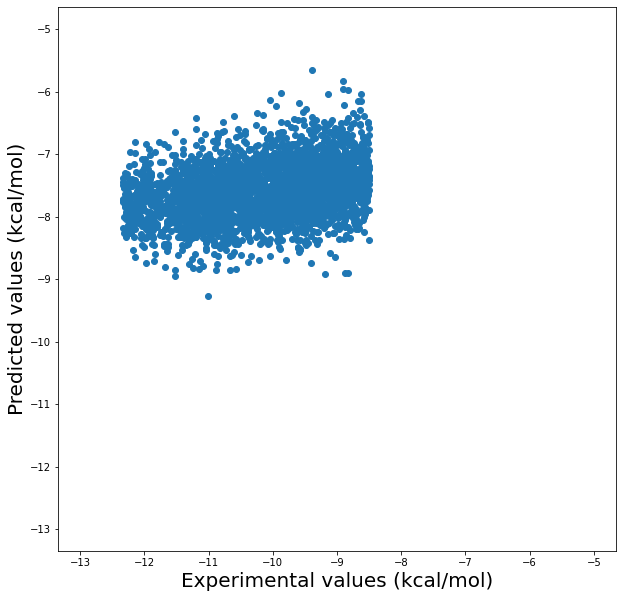

In [128]:
# Predict energy for test set
observed_pred = predict(model, likelihood, X_test_fps)
 
print('R2   : %.3f' % pearsonr(y_test, observed_pred.mean.numpy())[0]**2)
print('RMSD : %.3f kcal/mol' % rmsd(y_test, observed_pred.mean.numpy()))

# Plot results
plot(y_test.numpy(), observed_pred.mean.numpy(), fig_filename='correlation_exp_pred_MAP4_fps_tanimoto_mhc-i_cleaned_low_train_high_test_energy_split_-8.5.png')

In [129]:
np.sqrt(0.088)

0.2966479394838265

In [130]:
temperature = 300.
RT = 0.001987 * temperature
RT * np.log(1000 * 1e-9)

-8.235425843602503